# REBER Grammar with RNN

In this workbook, we are going to set-up multiple Recurrent Neural Network to test them using as test <a href="https://www.willamette.edu/~gorr/classes/cs449/reber.html" target="_blank">Reber's grammar</a> words.

## What is a Reber Word ?

A Reber word is a word following the Reber's grammar. The grammar is based on the following graph:

<img src="img/reber.gif"/>

The word must start with B, then it can be either T or P and so on until it reaches E. To prepare datas for this, we are going to use a OneHotEncoder to have 7 inputs, n timesteps (depending on the length of the word) and k batches. To generate it, I use the algorith from <a href="http://christianherta.de/lehre/dataScience/machineLearning/neuralNetworks/reberGrammar.php" target="_target">this site</a> but slightly modified to be able to validate also embedded Word

The Embedded version of the Reber Grammar using the following graph :

<img src="img/embreber.gif"/>

Our objective will be to classify real/fake Embedded Word. Due to current technologies, we will focus on Embedded Word (both system tried below with Simple Reber Word reaches 100% success and cannot be compared)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import random

import create_dataset as reber

from keras.datasets import imdb
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint, EarlyStopping

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

%matplotlib inline

Using TensorFlow backend.


## Preparation of datas

For the OneHotEncoder, the chain 'BTSXPVE' will be used. We can now try only 1 example to check the output

In [2]:
x, y = reber.get_one_embedded_example(minLength=10)
print(reber.sequenceToWord(x))
print(x[0], y[0])

BPBPTTVPXTVPXTVPXVVEP
[ 1.  0.  0.  0.  0.  0.  0.] [ 0.  1.  0.  0.  1.  0.  0.]


*y* is the possible outcome for a given input. That means B ([ 1.  0.  0.  0.  0.  0.  0.]) can be followed by T or P ([ 0.  1.  0.  0.  1.  0.  0.]).

Now we can generate words and set some of them wrong by changing random letter by another one.

In [3]:
def set_wrong(good_seq):
    index = np.random.randint(len(good_seq))
    letter = reber.sequenceToWord([good_seq[index]])
    new_letter = random.choice(list(set("BTSXPVE") - set(letter)))
    bad_seq = good_seq.copy()
    bad_seq[index] = np.array(reber.get_char_one_hot(new_letter)[0])
    return bad_seq

So we have the first "problem" now, the length of the string is variable. So when we are going to generate our test/train datas, we will have to pad them to the same length (whiwh will be equalt to the longest word). This is done by using <b>sequence.pad_sequences</b> for Keras Library. The padding will be done as "post" to improve accuracy. Using a "pre" padding reduce accuracy because the cell doesn't know how many times it will receive 0 instead of "E"

In [4]:
X_train, y_train = [], []
X_test, y_test = [], []
X_eval, y_eval = [], []
y_possible = []

maxlen = 0
min_length = 5
random_state = 42

for i in range(1024):
    x, y = reber.get_one_embedded_example(min_length)
    X_train.append(x)
    y_train.append(1)
    maxlen = max(maxlen, len(x))
    
for i in range(1024):
    x, y = reber.get_one_embedded_example(min_length)
    x = set_wrong(x)
    X_train.append(x)
    y_train.append(0)
    maxlen = max(maxlen, len(x))

for i in range(128):
    x, y = reber.get_one_embedded_example(min_length)
    X_test.append(x)
    y_test.append(1)
    maxlen = max(maxlen, len(x))
    
for i in range(128):
    x, y = reber.get_one_embedded_example(min_length)
    x = set_wrong(x)
    X_test.append(x)
    y_test.append(0)
    maxlen = max(maxlen, len(x))
    
for i in range(128):
    x, y = reber.get_one_embedded_example(min_length)
    X_eval.append(x)
    y_eval.append(1)
    maxlen = max(maxlen, len(x))
    
for i in range(128):
    x, y = reber.get_one_embedded_example(min_length)
    x = set_wrong(x)
    X_eval.append(x)
    y_eval.append(0)
    maxlen = max(maxlen, len(x))
    
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_eval = np.array(X_eval)
y_eval = np.array(y_eval)

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=random_state)
X_test, y_test = shuffle(X_test, y_test, random_state=random_state)
X_eval, y_eval = shuffle(X_eval, y_eval, random_state=random_state)

X_train = sequence.pad_sequences(X_train, maxlen=maxlen, padding='post', truncating='post')
X_test = sequence.pad_sequences(X_test, maxlen=maxlen, padding='post', truncating='post')
X_eval = sequence.pad_sequences(X_eval, maxlen=maxlen, padding='post', truncating='post')

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2048, 42, 7)
(2048,)
(256, 42, 7)
(256,)


So now we have 2048 strings for training, 256 for test and 256 for evaluation at the final end. We can now set-up our model.

## Test of RNNs

For this model, we are going to use one many-to-many followed by a one-to-many RNN. Like for standard ANN, the deeper we go, the more complexe the NN is able to understand things but the more time we need to train it.

<img src="img/RNN_types.jpg"/>

What we expect is a probability of having this or this letter. The problem is a multi-class classifier. As a reult, the loss function will be the categorical crossentropy

In [20]:
nb_unit = 7
inp_shape = (maxlen, 7)
loss_ = "binary_crossentropy"
metrics_ = "accuracy"
optimizer_ = "Adam"
nb_epoch = 250
batch_size = 64

### LSTM

The first model we will setup is an <b>LSTM</b> which means <b>L</b>ong <b>S</b>hort-<b>T</b>erm <b>M</b>emory. The principle is 
quite complex but very powerfull for long sequences inputs (because there is less issues with Vanishing Gradient Problem) or long term memory (You can refer to <a href="http://colah.github.io/posts/2015-08-Understanding-LSTMs/" target="_blank">this link</a> for more informations)

LSTM is widely for speech recognition, Natural Language processing, Sentiment Analysis.

In [21]:
model = Sequential()

model.add(LSTM(units=nb_unit, input_shape=inp_shape, return_sequences=True))
model.add(LSTM(units=nb_unit, input_shape=inp_shape))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=loss_,
              optimizer=optimizer_,
              metrics=[metrics_])

early = EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='auto')

Pay attention to have words of around 38-42 characters long. This reveal the différence between SRNN and LSTM/GRU

In [22]:
print("Inputs: {}".format(model.input_shape))
print("Outputs: {}".format(model.output_shape))
print("Actual input: {}".format(X_train.shape))
print("Actual output: {}".format(y_train.shape))

Inputs: (None, 42, 7)
Outputs: (None, 1)
Actual input: (2048, 42, 7)
Actual output: (2048,)


In [23]:
start = time.time()
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=nb_epoch, 
                    batch_size=batch_size, 
                    verbose=2, 
                    callbacks = [early])
stop = time.time()
t1 = stop-start
print(model.summary())
print("Training time : {}s".format(t1))
LSTM_steps = len(history.history["acc"])

Train on 2048 samples, validate on 256 samples
Epoch 1/250
 - 4s - loss: 0.6933 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/250
 - 3s - loss: 0.6932 - acc: 0.5015 - val_loss: 0.6931 - val_acc: 0.5195
Epoch 3/250
 - 3s - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6931 - val_acc: 0.5078
Epoch 4/250
 - 3s - loss: 0.6932 - acc: 0.5029 - val_loss: 0.6931 - val_acc: 0.4844
Epoch 5/250
 - 3s - loss: 0.6932 - acc: 0.4995 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/250
 - 3s - loss: 0.6933 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 7/250
 - 3s - loss: 0.6932 - acc: 0.4839 - val_loss: 0.6931 - val_acc: 0.5156
Epoch 8/250
 - 3s - loss: 0.6932 - acc: 0.4980 - val_loss: 0.6931 - val_acc: 0.5352
Epoch 9/250
 - 3s - loss: 0.6930 - acc: 0.5156 - val_loss: 0.6931 - val_acc: 0.4570
Epoch 10/250
 - 3s - loss: 0.6926 - acc: 0.5195 - val_loss: 0.6940 - val_acc: 0.4727
Epoch 11/250
 - 3s - loss: 0.6926 - acc: 0.5137 - val_loss: 0.6948 - val_acc: 0.5000
Epoch 12/250
 - 3s - loss: 

Epoch 97/250
 - 3s - loss: 0.1363 - acc: 0.9551 - val_loss: 0.1507 - val_acc: 0.9492
Epoch 98/250
 - 3s - loss: 0.1180 - acc: 0.9634 - val_loss: 0.1361 - val_acc: 0.9648
Epoch 99/250
 - 3s - loss: 0.1337 - acc: 0.9551 - val_loss: 0.1417 - val_acc: 0.9609
Epoch 100/250
 - 3s - loss: 0.1204 - acc: 0.9604 - val_loss: 0.1330 - val_acc: 0.9570
Epoch 101/250
 - 3s - loss: 0.1169 - acc: 0.9634 - val_loss: 0.1372 - val_acc: 0.9531
Epoch 102/250
 - 3s - loss: 0.1874 - acc: 0.9351 - val_loss: 0.6394 - val_acc: 0.7617
Epoch 103/250
 - 3s - loss: 0.2672 - acc: 0.9067 - val_loss: 0.2332 - val_acc: 0.9219
Epoch 104/250
 - 3s - loss: 0.1582 - acc: 0.9473 - val_loss: 0.1913 - val_acc: 0.9492
Epoch 105/250
 - 3s - loss: 0.1377 - acc: 0.9551 - val_loss: 0.1528 - val_acc: 0.9492
Epoch 106/250
 - 3s - loss: 0.1267 - acc: 0.9585 - val_loss: 0.1450 - val_acc: 0.9570
Epoch 107/250
 - 3s - loss: 0.1180 - acc: 0.9609 - val_loss: 0.1432 - val_acc: 0.9531
Epoch 108/250
 - 3s - loss: 0.1058 - acc: 0.9658 - val_lo

## Simple RNN

Using the same code, we can train the standard RNN. 

<img src="img/SimpleRNN.png"/>

This allows a "short term memory". It creates a kind of hysteresis used as memory

In [24]:
model2 = Sequential()
model2.add(SimpleRNN(units=nb_unit, input_shape=inp_shape, return_sequences=True))
model2.add(SimpleRNN(units=nb_unit, input_shape=inp_shape))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss=loss_,
              optimizer=optimizer_,
              metrics=[metrics_])

In [25]:
start = time.time()
history2 = model2.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=nb_epoch, 
                    batch_size=batch_size, 
                    verbose=2, 
                    callbacks = [early])
stop = time.time()
t2 = stop-start
print(model2.summary(), end=" ")
print("Training time : {}s".format(t2))
SRNN_steps = len(history2.history["acc"])

Train on 2048 samples, validate on 256 samples
Epoch 1/250
 - 2s - loss: 0.7319 - acc: 0.4985 - val_loss: 0.6996 - val_acc: 0.5156
Epoch 2/250
 - 1s - loss: 0.6991 - acc: 0.5010 - val_loss: 0.6915 - val_acc: 0.5469
Epoch 3/250
 - 1s - loss: 0.6939 - acc: 0.5083 - val_loss: 0.6893 - val_acc: 0.5273
Epoch 4/250
 - 1s - loss: 0.6921 - acc: 0.5269 - val_loss: 0.6883 - val_acc: 0.5352
Epoch 5/250
 - 1s - loss: 0.6904 - acc: 0.5151 - val_loss: 0.6869 - val_acc: 0.5312
Epoch 6/250
 - 1s - loss: 0.6873 - acc: 0.5376 - val_loss: 0.6843 - val_acc: 0.5234
Epoch 7/250
 - 1s - loss: 0.6773 - acc: 0.5874 - val_loss: 0.6718 - val_acc: 0.5938
Epoch 8/250
 - 1s - loss: 0.6563 - acc: 0.6284 - val_loss: 0.6593 - val_acc: 0.6133
Epoch 9/250
 - 1s - loss: 0.6380 - acc: 0.6475 - val_loss: 0.6505 - val_acc: 0.6172
Epoch 10/250
 - 1s - loss: 0.6295 - acc: 0.6475 - val_loss: 0.6412 - val_acc: 0.6250
Epoch 11/250
 - 1s - loss: 0.6214 - acc: 0.6567 - val_loss: 0.6351 - val_acc: 0.6172
Epoch 12/250
 - 1s - loss: 

Epoch 97/250
 - 1s - loss: 0.4565 - acc: 0.7852 - val_loss: 0.4419 - val_acc: 0.8164
Epoch 98/250
 - 1s - loss: 0.4614 - acc: 0.7910 - val_loss: 0.4712 - val_acc: 0.7930
Epoch 99/250
 - 1s - loss: 0.4536 - acc: 0.7920 - val_loss: 0.4353 - val_acc: 0.8164
Epoch 100/250
 - 1s - loss: 0.4493 - acc: 0.7993 - val_loss: 0.4450 - val_acc: 0.8164
Epoch 101/250
 - 1s - loss: 0.4545 - acc: 0.7930 - val_loss: 0.4376 - val_acc: 0.8047
Epoch 102/250
 - 1s - loss: 0.4552 - acc: 0.7920 - val_loss: 0.4602 - val_acc: 0.7930
Epoch 103/250
 - 1s - loss: 0.4621 - acc: 0.7842 - val_loss: 0.4548 - val_acc: 0.7773
Epoch 104/250
 - 1s - loss: 0.4534 - acc: 0.7954 - val_loss: 0.4513 - val_acc: 0.8008
Epoch 105/250
 - 1s - loss: 0.4534 - acc: 0.7915 - val_loss: 0.4798 - val_acc: 0.7852
Epoch 106/250
 - 1s - loss: 0.4508 - acc: 0.7944 - val_loss: 0.4519 - val_acc: 0.8125
Epoch 107/250
 - 1s - loss: 0.4548 - acc: 0.7925 - val_loss: 0.4902 - val_acc: 0.7734
Epoch 108/250
 - 1s - loss: 0.4482 - acc: 0.7974 - val_lo

## GRU

Finally, we can train a <b>GRU</b> (<b>G</b>ated <b>R</b>ecurrent <b>U</b>nits). It's a simplification of LSTMs. They also have a memory mechanism but with less parameters. As a result they are faster to train. You can find differences on <a href="https://datascience.stackexchange.com/questions/14581/what-is-difference-between-gru-and-lstm" target="_blank">this topic</a> 

In [26]:
model3 = Sequential()
model3.add(GRU(units=nb_unit, input_shape=inp_shape, return_sequences=True))
model3.add(GRU(units=nb_unit, input_shape=inp_shape))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss=loss_,
              optimizer=optimizer_,
              metrics=[metrics_])

In [27]:
start = time.time()
history3 = model3.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=nb_epoch, 
                    batch_size=batch_size, 
                    verbose=2, 
                    callbacks = [early])
stop = time.time()
t3 = stop-start
print(model3.summary(), end=" ")
print("Training time : {}s".format(t3))
GRU_steps = len(history3.history["acc"])

Train on 2048 samples, validate on 256 samples
Epoch 1/250
 - 4s - loss: 0.6932 - acc: 0.4990 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/250
 - 2s - loss: 0.6933 - acc: 0.4888 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 3/250
 - 2s - loss: 0.6932 - acc: 0.4888 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 4/250
 - 2s - loss: 0.6932 - acc: 0.4971 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 5/250
 - 2s - loss: 0.6931 - acc: 0.4883 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/250
 - 2s - loss: 0.6932 - acc: 0.4927 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 7/250
 - 2s - loss: 0.6931 - acc: 0.4834 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 8/250
 - 2s - loss: 0.6933 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 9/250
 - 2s - loss: 0.6931 - acc: 0.4712 - val_loss: 0.6931 - val_acc: 0.5039
Epoch 10/250
 - 2s - loss: 0.6931 - acc: 0.5010 - val_loss: 0.6931 - val_acc: 0.5039
Epoch 11/250
 - 2s - loss: 0.6931 - acc: 0.4893 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 12/250
 - 2s - loss: 

Epoch 97/250
 - 2s - loss: 0.1557 - acc: 0.9502 - val_loss: 0.1149 - val_acc: 0.9648
Epoch 98/250
 - 2s - loss: 0.1628 - acc: 0.9478 - val_loss: 0.1447 - val_acc: 0.9570
Epoch 99/250
 - 2s - loss: 0.1658 - acc: 0.9468 - val_loss: 0.1383 - val_acc: 0.9648
Epoch 100/250
 - 2s - loss: 0.1453 - acc: 0.9580 - val_loss: 0.1198 - val_acc: 0.9609
Epoch 101/250
 - 2s - loss: 0.1320 - acc: 0.9580 - val_loss: 0.1625 - val_acc: 0.9453
Epoch 102/250
 - 2s - loss: 0.1413 - acc: 0.9561 - val_loss: 0.1220 - val_acc: 0.9688
Epoch 103/250
 - 2s - loss: 0.1243 - acc: 0.9619 - val_loss: 0.1221 - val_acc: 0.9688
Epoch 104/250
 - 2s - loss: 0.1358 - acc: 0.9585 - val_loss: 0.1830 - val_acc: 0.9414
Epoch 105/250
 - 2s - loss: 0.1377 - acc: 0.9600 - val_loss: 0.1283 - val_acc: 0.9688
Epoch 106/250
 - 2s - loss: 0.1272 - acc: 0.9619 - val_loss: 0.1186 - val_acc: 0.9688
Epoch 107/250
 - 2s - loss: 0.1186 - acc: 0.9624 - val_loss: 0.1092 - val_acc: 0.9727
Epoch 108/250
 - 2s - loss: 0.1174 - acc: 0.9644 - val_lo

Epoch 00192: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 42, 7)             315       
_________________________________________________________________
gru_2 (GRU)                  (None, 7)                 315       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 8         
Total params: 638
Trainable params: 638
Non-trainable params: 0
_________________________________________________________________
None Training time : 459.7016022205353s


## Evaluation

We can first check the time used to train them and the number of epochs required before EarlyStop

In [28]:
print("LSTM :       {:.2f}s - {} epoch".format(t1, LSTM_steps))
print("Simple RNN : {:.2f}s - {} epoch".format(t2, SRNN_steps))
print("GRU :        {:.2f}s - {} epoch".format(t3, GRU_steps))

LSTM :       449.26s - 148 epoch
Simple RNN : 103.33s - 139 epoch
GRU :        459.70s - 192 epoch


We can see that the simple RNN is the fastest to train because there is nearly no impact of provide the output as input. It's only and addtion to do on Matrices. However, LSTM and GRU are slower to train and as expected, GRU trained faster than LSTM.

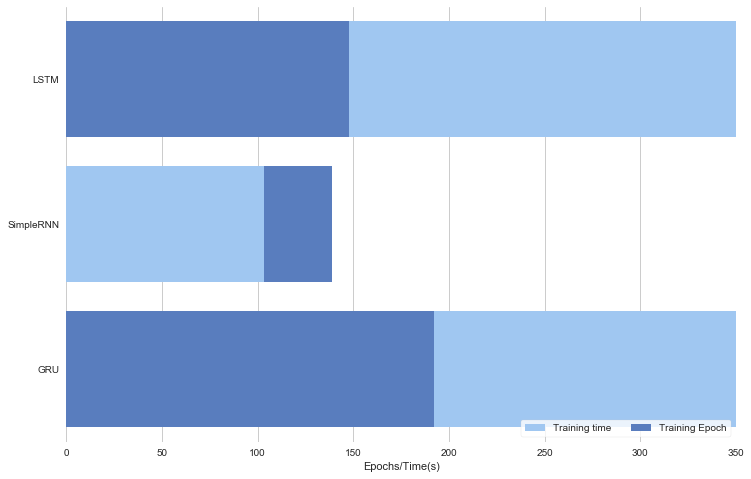

In [30]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(12, 8))

sns.set_color_codes("pastel")
sns.barplot(x=[t1, 0, t3] , y=["LSTM", "SimpleRNN", "GRU"], label="Training time", color="b")

sns.set_color_codes("muted")
sns.barplot(x=[LSTM_steps, SRNN_steps, GRU_steps], y=["LSTM", "SimpleRNN", "GRU"], label="Training Epoch", color="b")

# just because SRNN step > time
sns.set_color_codes("pastel")
sns.barplot(x=[0, t2, 0] , y=["LSTM", "SimpleRNN", "GRU"], color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 350), ylabel="",
       xlabel="Epochs/Time(s)")
sns.despine(left=True, bottom=True)
plt.savefig("barplot.png")
plt.show()

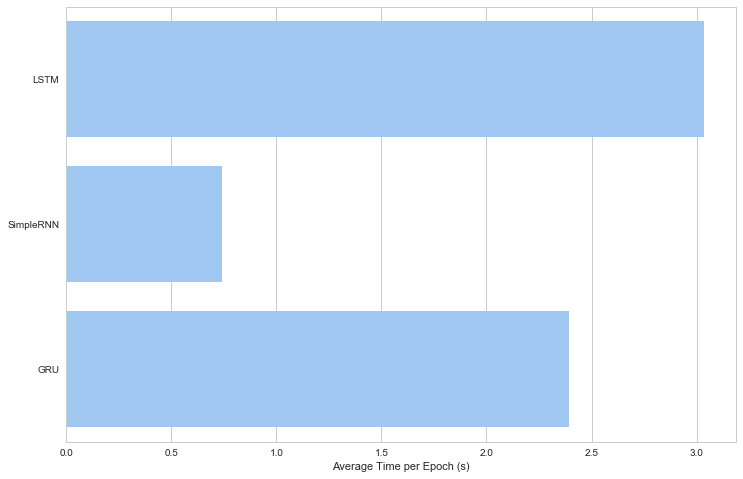

In [33]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(12, 8))

sns.set_color_codes("pastel")
sns.barplot(x=[t1/LSTM_steps, t2/SRNN_steps, t3/GRU_steps] , y=["LSTM", "SimpleRNN", "GRU"], color="b")

# ax.set(xlim=(0, 350), ylabel="", xlabel="Epochs/Time(s)")
# sns.despine(left=True, bottom=True)
plt.xlabel("Average Time per Epoch (s)")
plt.savefig("barplot_time.png")
plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


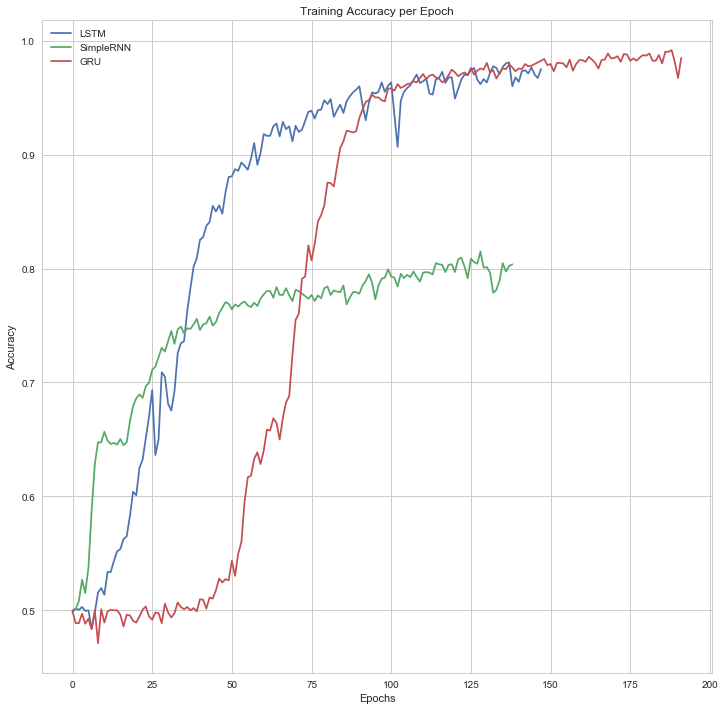

In [34]:
print(history.history.keys())
key_ = "acc" # list(history.history.keys())[3]
plt.figure(figsize=(12, 12))
plt.plot(history.history[key_], label="LSTM")
plt.plot(history2.history[key_], label="SimpleRNN")
plt.plot(history3.history[key_], label="GRU")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Training Accuracy per Epoch")
plt.savefig("accuracy.png")
plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


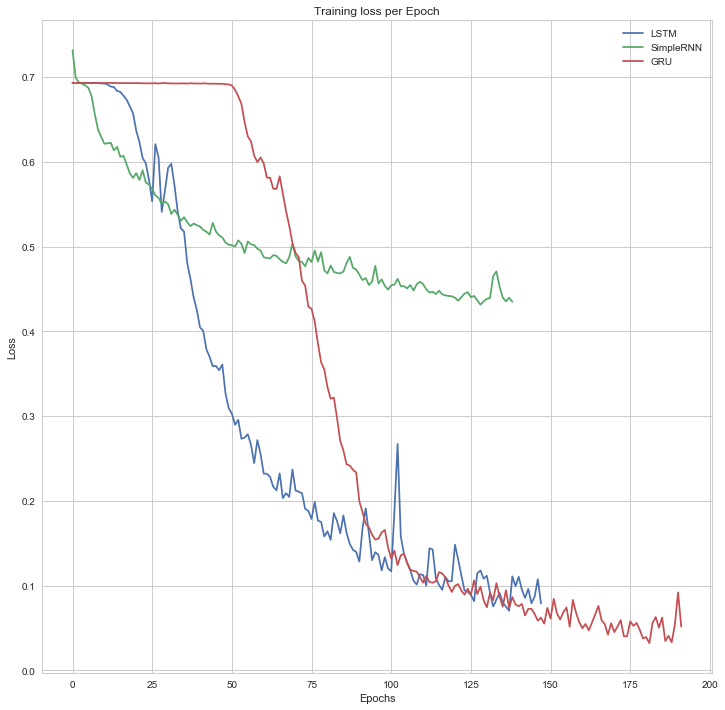

In [35]:
print(history.history.keys())
key_ = "loss" # list(history.history.keys())[3]
plt.figure(figsize=(12, 12))
plt.plot(history.history[key_], label="LSTM")
plt.plot(history2.history[key_], label="SimpleRNN")
plt.plot(history3.history[key_], label="GRU")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Training loss per Epoch")
plt.savefig("loss.png")
plt.show()

We can see that GRU and LSTM perform better than a Simple RNN. LSTM is also performing slightly better that GRU but require more computation time. We can also check the output and compare it to the real output provided by the graph (see the y description in preparation of data section)

In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, log_loss

In [37]:
y_pred = model.predict(X_eval)

y_pred_floor= np.around(y_pred)

print(accuracy_score(y_eval, y_pred_floor))
print(confusion_matrix(y_eval, y_pred_floor))
print(precision_score(y_eval, y_pred_floor))
print(recall_score(y_eval, y_pred_floor))
print(f1_score(y_eval, y_pred_floor))
print(log_loss(y_eval, y_pred))

0.96875
[[122   6]
 [  2 126]]
0.954545454545
0.984375
0.969230769231
0.0964980389554


In [38]:
y_pred = model2.predict(X_eval)

y_pred_floor= np.around(y_pred)

print(accuracy_score(y_eval, y_pred_floor))
print(confusion_matrix(y_eval, y_pred_floor))
print(precision_score(y_eval, y_pred_floor))
print(recall_score(y_eval, y_pred_floor))
print(f1_score(y_eval, y_pred_floor))
print(log_loss(y_eval, y_pred))

0.7578125
[[100  28]
 [ 34  94]]
0.770491803279
0.734375
0.752
0.48050892388


In [39]:
y_pred = model3.predict(X_eval)

y_pred_floor= np.around(y_pred)

print(accuracy_score(y_eval, y_pred_floor))
print(confusion_matrix(y_eval, y_pred_floor))
print(precision_score(y_eval, y_pred_floor))
print(recall_score(y_eval, y_pred_floor))
print(f1_score(y_eval, y_pred_floor))
print(log_loss(y_eval, y_pred))

0.984375
[[125   3]
 [  1 127]]
0.976923076923
0.9921875
0.984496124031
0.0586241011113


## Conclusion

In this workbook, we started to go through RNN. We trained 3 models to classify either a word is or isn't following Reber's rule. Further topolies can be used to improve performances (more layers, fully connected layer?).